### Importation des librairies

In [1]:
# Structures
from sklearn.decomposition import PCA
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE
from texthero import preprocessing
from texthero import kmeans
import texthero as hero
import wordcloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string
import re
import nltk
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# corpus processing
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vincentMalfroy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincentMalfroy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vincentMalfroy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vincentMalfroy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Fonctions

In [ ]:
def extract_main_categories(sentence):
    extract = sentence.split('>>')[0]
    extract = ''.join(ch for ch in extract if ch.isalnum())
    return extract

In [ ]:
from sklearn.manifold import TSNE


def plot_tsne(matrix, title, labels):

    tsne = TSNE(n_components=2,
                random_state=5,
                perplexity=600,
                n_iter=5000).fit_transform(matrix)

    tsne_data = np.vstack((tsne.T, labels)).T
    tsne_df = pd.DataFrame(tsne_data,
                           columns=['tsne-one', 'tsne-two', 'category'])

    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    sns.scatterplot(data=tsne_df,
                    x="tsne-one",
                    y="tsne-two",
                    hue='category',
                    ax=ax)
    plt.title('TSNE Cluster Plot'+' '+title)

In [ ]:
def pca_function(to_fit):
    pca = PCA(n_components=0.95,  # 95% cumulated variance
              random_state=0,
              ).fit(to_fit)
    x = pca.transform(to_fit)
    print("Dimensions dataset après réduction PCA : ", x.shape, end='\n\n')
    return pca, x

In [ ]:
def pca_graph(pca):
    cum_var = pca.explained_variance_ratio_*100  # percentage
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(cum_var))+1, np.cumsum(cum_var))
    plt.title('Somme cumulée de variance des composantes du PCA : 95%')
    plt.xlabel('Nombre de composantes du PCA')
    plt.ylabel('Variance cumulée (%)')
    plt.axhline(95, lw=1, c='red')
    plt.text(1, 95, '95%', c='red')
    plt.show()

In [ ]:
def tsne_pca(to_fit):
    tsne = TSNE(n_components=2,
                random_state=5,
                perplexity=600,
                n_iter=5000)
    x = tsne.fit_transform(to_fit)
    x_df = pd.DataFrame(x[:, 0:2], columns=['tsne1', 'tsne2'])
    print("Dimensions dataset après réduction tsne : ", x.shape, end='\n\n')
    return tsne, x, x_df

In [ ]:
def tsne_graph(x):
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    sns.scatterplot(data=x,
                    x="tsne1",
                    y="tsne2",
                    hue='categories',
                    legend='brief',
                    palette=sns.color_palette('tab10', n_colors=7),
                    s=50,
                    alpha=0.6,
                    ax=ax)
    plt.title('PCA Cluster Plot')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')
    plt.legend(prop={'size': 14})
    plt.show()

In [2]:
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 350)
pd.set_option("display.max_colwidth", 2500)

### Importation des polices et des caractères

In [3]:
font_title = {
    "family": "Times New Roman",
    "color": "blue",
    "weight": "bold",
    "size": 20
}


class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

### Importations de tous les datasets

In [4]:
produits = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [5]:
produits.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                                                       product_url  \
0       http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                       http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2                              http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4   
4            http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]   
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [6]:
# Analyse des types
produits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
print("{} lignes et {} colonnes".format(produits.shape[0], produits.shape[1]))

1050 lignes et 15 colonnes


In [8]:
print("Les moyennes des valeurs manquantes dans le DS : {} \n".format(
    produits.isna().mean()))

Les moyennes des valeurs manquantes dans le DS : uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
retail_price               0.000952
discounted_price           0.000952
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
brand                      0.321905
product_specifications     0.000952
dtype: float64 



In [9]:
produits['product_category_tree']

0                                ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]
2        ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
3         ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]
4                  ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]
                                                                          ...                                                                    
1045                                                                      ["Baby Care >> Baby & Kids Gifts >> Stickers >> Or

Nous allons extraitre la classe principale des prodits 
Nous allons transformer les catégories de produits en numérique cela pourra servir pour les clusters 

In [11]:
produits['categories'] = produits.product_category_tree.apply(
    lambda tree: extract_main_categories(tree))

cluster = {'HomeFurnishing': 0,
           'BabyCare': 1,
           'Watches': 2,
           'HomeDecorFestiveNeeds': 3,
           'KitchenDining': 4,
           'BeautyandPersonalCare': 5,
           'Computers': 6}

produits['label_categories'] = produits['categories'].map(cluster)

Text(0.5, 1.0, 'Distribution des produits selon leur catégorie')

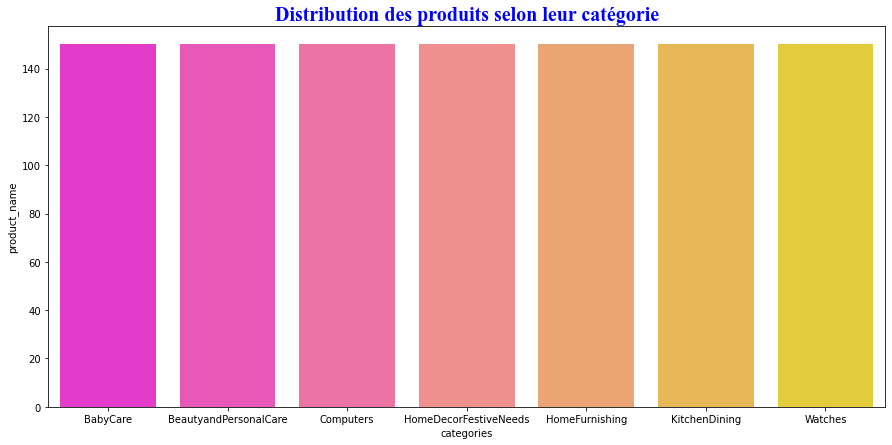

In [12]:
fig = plt.figure(figsize=[15, 7])
product_categories = produits[['product_name', 'categories']]\
    .groupby('categories').count().reset_index()
product_categories = product_categories.sort_values(by=['product_name'],
                                                    ascending=False)

sns.barplot(x='categories',
            y='product_name',
            data=product_categories,
            palette='spring')
plt.title('Distribution des produits selon leur catégorie', fontdict=font_title)

## Text cleaning

* mettre tous les mots en minuscule
* ne garder que les caractères alphabétiques
* supprimer les stopwords et les lettres isolées
* lemmatisation


Pour cette étape, j'utilise la bilibliothèque texthero.



In [13]:
import texthero as hero
from texthero import preprocessing

In [14]:
corpus = produits[['categories', 'description', 'product_name']]

In [15]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls,
                   preprocessing.remove_digits,
                   preprocessing.drop_no_content,
                   preprocessing.remove_round_brackets]

In [16]:
corpus['clean_description'] = corpus['description'].pipe(hero.clean,
                                                         custom_pipeline)

corpus['clean_product_name'] = corpus['product_name'].pipe(hero.clean,
                                                           custom_pipeline)

In [17]:
index = 600
text = corpus['description'][index]
print(color.BOLD + 'Texte original: \n' + color.END, text)

text_modifier = corpus['clean_description'][index]
print(color.BOLD + 'Texte modifié: \n' + color.END, text_modifier)

Texte original: 
 Key Features of R&Mshoppee MDF Wall Shelf Trendy & Stylish easy to assemble,R&Mshoppee MDF Wall Shelf (Number of Shelves - 1, Black) Price: Rs. 725 this H shape wall shelf will increase decoration of your walls you can use it as book shelf , dvd shelf or can keep show pieces on it .,Specifications of R&Mshoppee MDF Wall Shelf (Number of Shelves - 1, Black) General Brand R&Mshoppee Suitable For Living Room & Bedroom Model Number r&m0179 Material MDF Color Black Body & Design Features Number of Shelves 1 In the Box Sales Package 1 shelf Additional Features Other Features screw included
Texte modifié: 
 key features of r mshoppee mdf wall shelf trendy   stylish easy to assemble r mshoppee mdf wall shelf  number of shelves      black  price  rs    this h shape wall shelf will increase decoration of your walls you can use it as book shelf   dvd shelf or can keep show pieces on it  specifications of r mshoppee mdf wall shelf  number of shelves      black  general brand r ms

In [18]:
def remove_noise(text):
    # Retirer les nombres et les mots concatener
    text = re.sub("\S*\d\S*", " ", text)
    text = re.sub("\S*@\S*\s?", " ", text)  # Retirer les mentions et les mails
    text = re.sub(r'[^\x00-\x7f]', r' ', text)
    text = re.sub('\W_', ' ', text)
    return text

In [19]:
corpus['description_clean'] = corpus['clean_description'].apply(
    lambda x: remove_noise(x))
corpus['product_name_clean'] = corpus['clean_product_name'].apply(
    lambda x: remove_noise(x))

In [20]:
index = 600
text = corpus['clean_description'][index]
print(color.BOLD + 'Texte : \n' + color.END, text)

text_modifier = corpus['description_clean'][index]
print(color.BOLD + 'Texte modifié: \n' + color.END, text_modifier)

Texte : 
 key features of r mshoppee mdf wall shelf trendy   stylish easy to assemble r mshoppee mdf wall shelf  number of shelves      black  price  rs    this h shape wall shelf will increase decoration of your walls you can use it as book shelf   dvd shelf or can keep show pieces on it  specifications of r mshoppee mdf wall shelf  number of shelves      black  general brand r mshoppee suitable for living room   bedroom model number r m0179 material mdf color black body   design features number of shelves   in the box sales package   shelf additional features other features screw included
Texte modifié: 
 key features of r mshoppee mdf wall shelf trendy   stylish easy to assemble r mshoppee mdf wall shelf  number of shelves      black  price  rs    this h shape wall shelf will increase decoration of your walls you can use it as book shelf   dvd shelf or can keep show pieces on it  specifications of r mshoppee mdf wall shelf  number of shelves      black  general brand r mshoppee suit

## Tokenization pour connaitre les mots les plus utilisés du corpus

In [21]:
description = corpus['description_clean']

In [22]:
tokenize = nltk.RegexpTokenizer(r'\w+')


def corpora_stats_freq(dscp=description):
    corpora = defaultdict(list)
    stats = defaultdict(dict)
    freq = defaultdict(dict)

    for k, v in dscp.iteritems():
        tmp = tokenize.tokenize(v)
        corpora[k] = tmp
        freq[k] = fq = nltk.FreqDist(tmp)
        stats[k] = {'total_words': len(tmp), 'unique_words': len(fq.keys())}

    return (freq, stats, corpora)


# Récupération des comptages
corpora, freq, stats = corpora_stats_freq(description)
df = pd.DataFrame.from_dict(freq, orient='index')

In [23]:
df

total_words  unique_words
0             225           127
1              67            43
2             197           114
3             124            59
4             186            95
...           ...           ...
1045          409           140
1046          285            98
1047           35            27
1048           29            23
1049           27            23

[1050 rows x 2 columns]

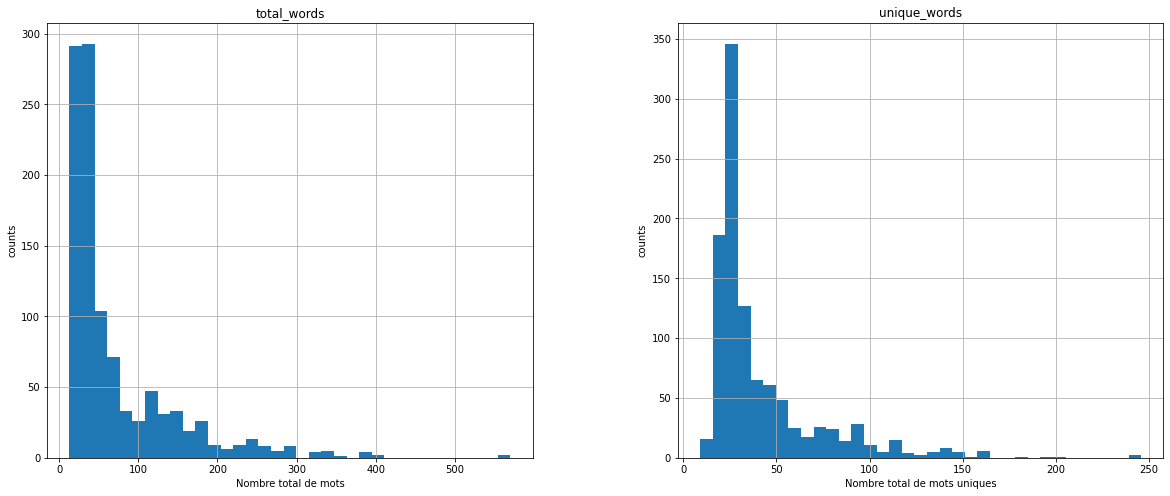

In [24]:
ax = df.hist(bins=35, figsize=(20, 8))
ax[0, 0].set(ylabel='counts', xlabel='Nombre total de mots')
ax[0, 1].set(ylabel='counts', xlabel='Nombre total de mots uniques')
plt.show()

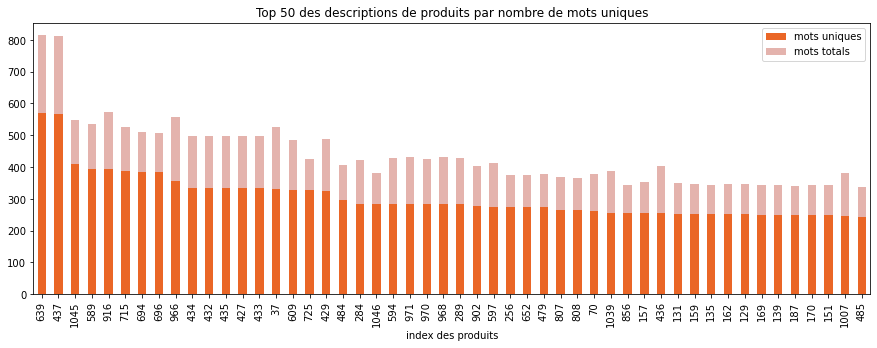

In [25]:
mots_uniques = df.sort_values('total_words', ascending=False)
t = 'Top 50 des descriptions de produits par nombre de mots uniques'
c = ['#ea6626', '#e4b3ad']
ax = mots_uniques[:50].plot(kind='bar',
                            stacked=True,
                            title=t,
                            color=c,
                            figsize=(15, 5))
ax.set_xlabel('index des produits')
ax.legend(['mots uniques', 'mots totals'])
plt.show()

## Tokenisation

In [26]:
freq_totale = nltk.Counter()
for k, v in freq.items():
    freq_totale += freq[k]

most_freq, _ = zip(*freq_totale.most_common(100))
default = nltk.corpus.stopwords.words('english')
sw = set()
sw.update(most_freq), sw.update(default)

(None, None)

In [27]:
def corpora_stats_freq2(dscp=description, stopword=sw):
    corpora = defaultdict(list)
    freq = defaultdict(dict)
    total = []
    n_uniq = []

    for k, v in dscp.iteritems():
        tokens = tokenize.tokenize(v)
        # Supprimer les stopwords par défaut et les mots les plus courants
        tmp = [w for w in tokens if not w in stopword]
        # corpora dict : index comme keys, token list comme valeurs
        corpora[k] = tmp
        freq[k] = fq = nltk.FreqDist(tmp)
        total.append(len(tmp))
        n_uniq.append(len(freq[k].keys()))

    stat = pd.DataFrame().assign(unique_words=n_uniq, total_words=total)
    return corpora, freq, stat

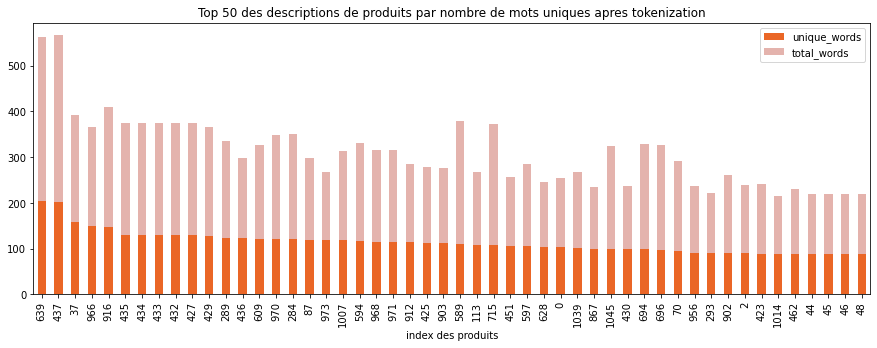

In [28]:
corpora2, freq2, stat2 = corpora_stats_freq2(description, sw)
freq_total2 = nltk.Counter()
for k, v in freq2.items():
    freq_total2 += v

unique_words = stat2.sort_values("unique_words", ascending=False)
titre = 'Top 50 des descriptions de produits par nombre de mots uniques apres tokenization'
color = ['#ea6626', '#e4b3ad']
ax = unique_words[:50].plot(kind='bar',
                            stacked=True,
                            title=titre,
                            color=color,
                            figsize=(15, 5))
ax.set_xlabel('index des produits')
plt.show()

## Suppresion des stopwords les plus fréquents en anglais 

In [29]:
corpus["description_stopword"] = hero.remove_stopwords(
    corpus["description_clean"])
corpus["name_stopword"] = hero.remove_stopwords(corpus["product_name_clean"])

## Suppresion des mots trop courts ou trop longs

In [30]:
def short_words(text):
    nltk_tokens = nltk.word_tokenize(text)
    lettres = []
    for token in nltk_tokens:
        if len(token) <= 3:
            lettres.append(token)
    corpus = [word for word in nltk_tokens if word not in lettres]
    return ' '.join(map(str, corpus))


corpus["description_short"] = corpus["description_stopword"].apply(
    lambda x: short_words(x))
corpus["name_short"] = corpus["name_stopword"].apply(
    lambda x: short_words(x))

## Lemmatisation

Nous allons pouvoir utiliser le processus de lemmatisation qui consiste à représenter les mots sous leur forme canonique, c'est à dire un verbe sous sa forme infinitive, un nom en masculin singulier  

In [31]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(text):
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is 'r':
            lemmatized_sentence.append('')
        elif tag is 'a':
            lemmatized_sentence.append('')
        elif tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [32]:
corpus['description_lemmatisation'] = corpus['description_short'].apply(
    lambda x: get_wordnet_pos(x))
corpus['name_lemmatisation'] = corpus['name_short'].apply(
    lambda x: get_wordnet_pos(x))
corpus

categories  \
0     HomeFurnishing   
1           BabyCare   
2           BabyCare   
3     HomeFurnishing   
4     HomeFurnishing   
...              ...   
1045        BabyCare   
1046        BabyCare   
1047        BabyCare   
1048        BabyCare   
1049        BabyCare   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstrac

In [33]:
descriptions = corpus['description_lemmatisation']

In [34]:
def corpora_stats_freq2(dscp=descriptions):
    corpora2 = defaultdict(list)
    stats2 = defaultdict(dict)
    freq2 = defaultdict(dict)
    total2 = []
    n_uniq2 = []

    for k, v in dscp.iteritems():
        tmp2 = tokenize.tokenize(v)
        # corpora dict : index comme keys, token list comme valeurs
        corpora2[k] = tmp2
        freq2[k] = fq = nltk.FreqDist(tmp2)
        total2.append(len(tmp2))
        n_uniq2.append(len(freq2[k].keys()))

    stat = pd.DataFrame().assign(unique_words=n_uniq2, total_words=total2)
    return corpora2, freq2, stats2

In [35]:
mots_utilises = nltk.Counter()
for k, v in freq2.items():
    mots_utilises += freq2[k]

most_freq, _ = zip(*mots_utilises.most_common(100))
sw = set()
sw.update(mots_utilises)

In [36]:
mots_utilises.most_common(160)

[('rs', 911),
 ('products', 631),
 ('free', 618),
 ('buy', 581),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('replacement', 559),
 ('cm', 543),
 ('day', 540),
 ('flipkart', 481),
 ('com', 473),
 ('guarantee', 471),
 ('online', 396),
 ('features', 395),
 ('specifications', 371),
 ('price', 352),
 ('watch', 330),
 ('color', 328),
 ('mug', 327),
 ('baby', 320),
 ('pack', 317),
 ('material', 312),
 ('set', 310),
 ('type', 304),
 ('cotton', 299),
 ('box', 292),
 ('general', 288),
 ('package', 269),
 ('analog', 262),
 ('sales', 261),
 ('number', 253),
 ('warranty', 250),
 ('quality', 245),
 ('details', 235),
 ('product', 233),
 ('brand', 232),
 ('best', 230),
 ('model', 226),
 ('design', 225),
 ('ceramic', 219),
 ('key', 215),
 ('laptop', 214),
 ('fabric', 211),
 ('prices', 209),
 ('showpiece', 206),
 ('made', 189),
 ('great', 189),
 ('perfect', 184),
 ('india', 180),
 ('men', 177),
 ('size', 176),
 ('inch', 174),
 ('usb', 174),
 ('dimensions', 167),
 ('ideal

In [37]:
most_common = ['rs', 'products', 'free', 'buy', 'delivery', 'genuine', 'shipping',
               'cash', 'replacement', 'cm', 'day', 'flipkart', 'com', 'guarantee',
               'online', 'features', 'specifications', 'price', 'color', 'pack',
               'material', 'set', 'type', 'general', 'package', 'sales', 'number',
               'warranty', 'quality', 'details', 'product', 'dimension',
               'brand', 'best', 'model', 'design', 'key', 'fabric', 'prices', 'showpiece',
               'made', 'great', 'perfect', 'india', 'men', 'love', 'size', 'inch',
               'dimensions', 'ideal', 'girl', 'multicolor', 'combo', 'gift', 'women',
               'x', 'printed', 'like', 'make', 'discounts', 'width', 'black', 'wash',
               'also', 'print', 'care', 'blue',  'ml', 'power', 'use',
               'height', 'yes', 'pattern', 'high', 'l', 'style', 'length', 'one',
               'easy', 'name', 'specification', 'feature', 'make', 'sale',
               'give', 'weight', 'round', 'designed', 'discount', 'need', 'please']

In [38]:
def supp_most_common(text, most_common):
    nltk_tokens = nltk.word_tokenize(text)

    corpus = [w for w in nltk_tokens if not w in most_common]
    return ' '.join(map(str, corpus))


corpus["description_lemmatisation"] = corpus["description_lemmatisation"].apply(
    lambda x: supp_most_common(x, most_common))

## Tokenisation

In [39]:
def tokenization(text):
    nltk_tokens = nltk.word_tokenize(text)

    ordered_tokens = set()
    result = []
    for word in nltk_tokens:
        if word not in ordered_tokens:
            ordered_tokens.add(word)
            result.append(word)
    return " ".join(result)

In [40]:
corpus["description_lemmatisation"] = corpus[
    "description_lemmatisation"].apply(lambda x: tokenization(x))
corpus["name_lemmatisation"] = corpus["name_lemmatisation"].apply(
    lambda x: tokenization(x))

## Corpus final

In [41]:
corpus_final = corpus[['categories', 'description_lemmatisation',
                       'name_lemmatisation']]

In [42]:
corpus_final

categories  \
0     HomeFurnishing   
1           BabyCare   
2           BabyCare   
3     HomeFurnishing   
4     HomeFurnishing   
...              ...   
1045        BabyCare   
1046        BabyCare   
1047        BabyCare   
1048        BabyCare   
1049        BabyCare   

                                                                                                                                                                                                                                                                                                                                              description_lemmatisation  \
0                                                   elegance polyester eyelet door curtain enhances look interior stitch metal ring room environment loving wrinkle shrinkage apparance home bright appeal attention heart valance slide thing morning ray want world draw evening create moment beauty soothe bring elegant filter light right amount sunlight content   
1                                                                                                                                                                                                                                                                                                     sathiyas cotton bath towel machine self woman boys mediam content   
2                                                                                                                                                               eurospa cotton terry face towel piece bring export texture take enrich feel deserve bath renowned year absorbency softness durability note shrinkage picture water iron bleach assort boy woman content   
3                                                                                                                                                                                                                                                          santosh fashion cotton king bedsheet perfact wed cover machine wedding pillow bleach sheet fit depth content   
4                                                                                                                                                                                                  jaipur cotton king bedsheet sheet comfort hand look room life cover machine thread count bleach waranty manufacturing exchange onle packing fit pillow depth content   
...                                                                                                                                                                                                                                                                                                                                                                 ...   
1045  oren empower self sticker wall piece arrange look tree green shade leaf greenery reusable remove another idea install surface attach must clean dust grease contamination peel back paper apply desire area note paint allow recommend wait week discourage installation brick stucco concrete block suede sand bubble take help friend family member stick decal   
1046                                                                                                                                                           vinyl sticker bring home piece wall refreshing look deserve decal trend world interior personalise transform wallmantra premium self ensure remove apply practice item instruction manual contact option   
1047                                                                                                                                                                                                                                                                                                                         pigment polyvinyl film import sticker ship   
1048                                                                                       

Nous allons nous servir que de la variable 'description_lemmatisation' dans la mesure ou name lemmatisation se retrouve dans la description 

## Wordcloud

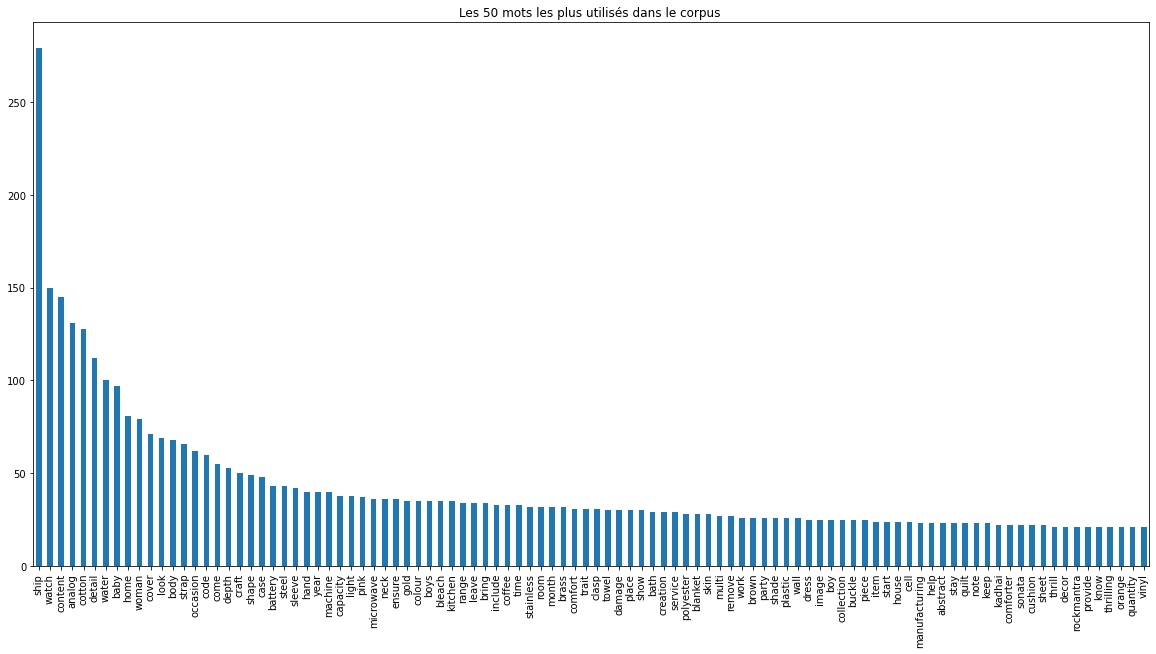

In [43]:
Num_TOP_WORDS = 100
top_100 = hero.visualization.top_words(
    corpus["description_lemmatisation"]).head(Num_TOP_WORDS)

fig = plt.figure(figsize=(20, 10))
top_100.plot.bar(rot=90, title="Les 50 mots les plus utilisés dans le corpus ")
plt.show(block=True)

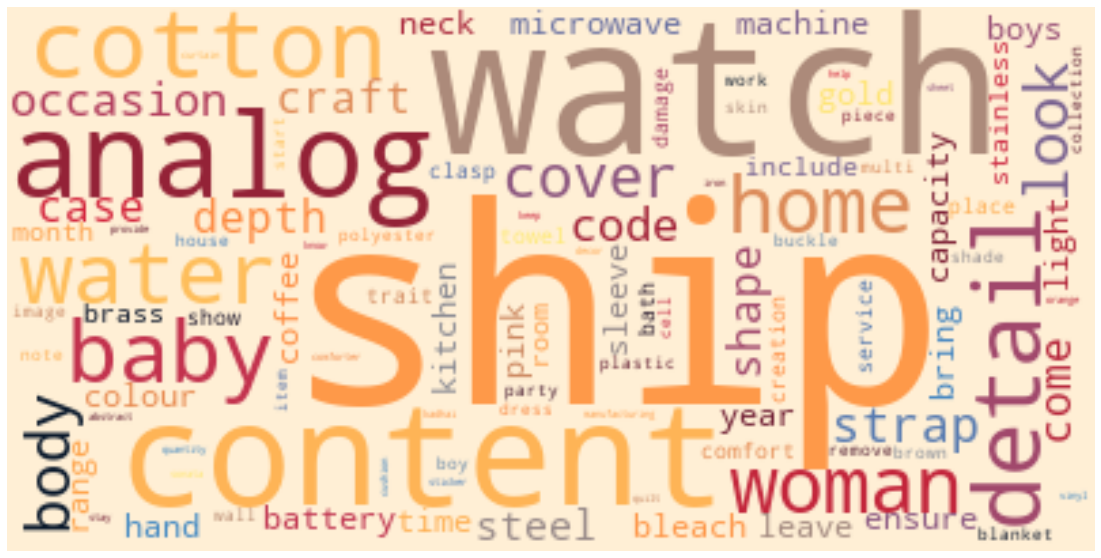

In [44]:
hero.wordcloud(corpus.description_lemmatisation, max_words=100,)

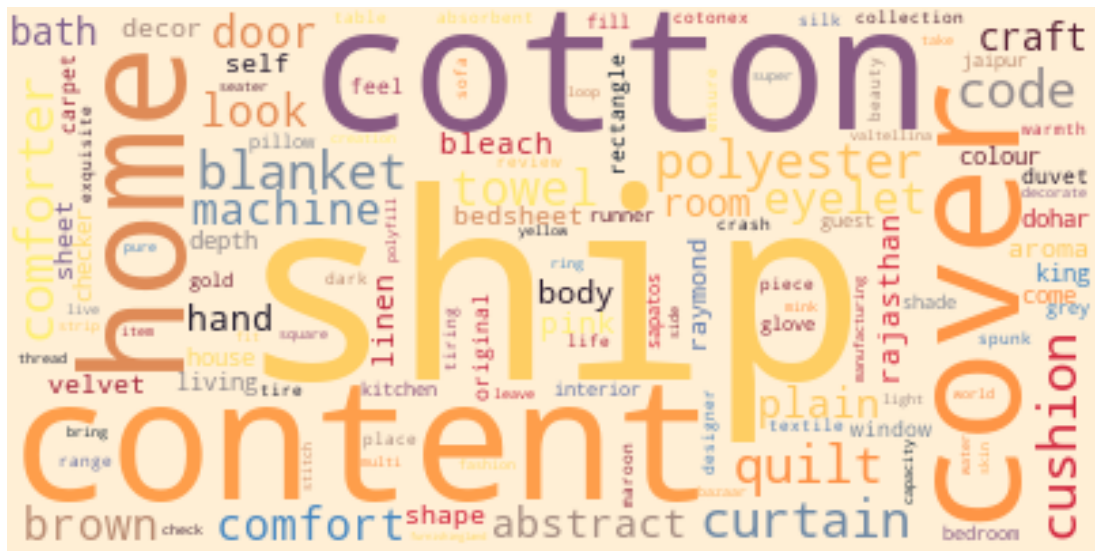

In [45]:
hero.wordcloud(corpus_final[corpus_final['categories'] ==
               'HomeFurnishing']['description_lemmatisation'], max_words=200,)

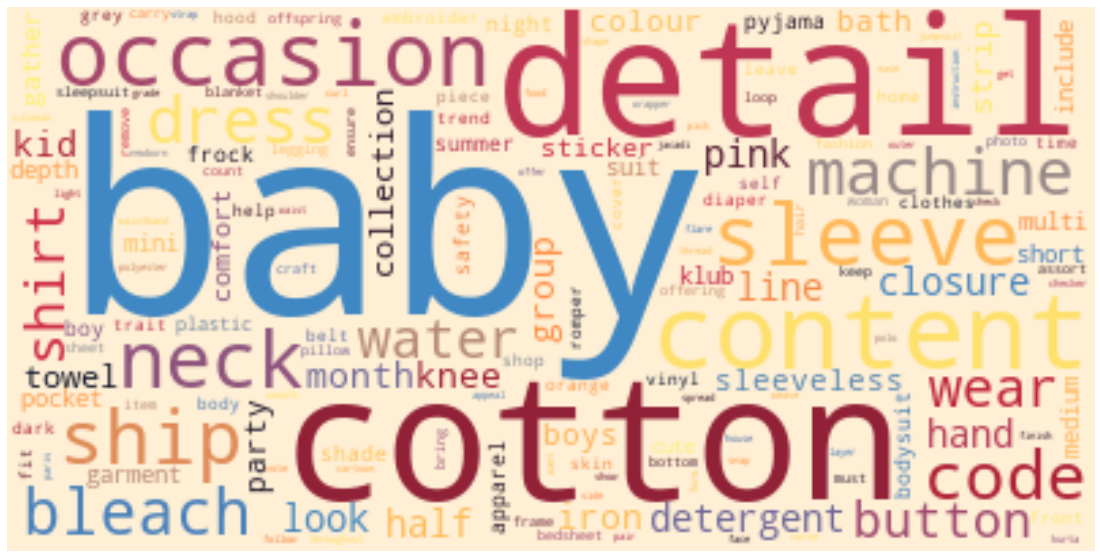

In [46]:
hero.wordcloud(corpus_final[corpus_final['categories'] ==
               'BabyCare']['description_lemmatisation'], max_words=200,)

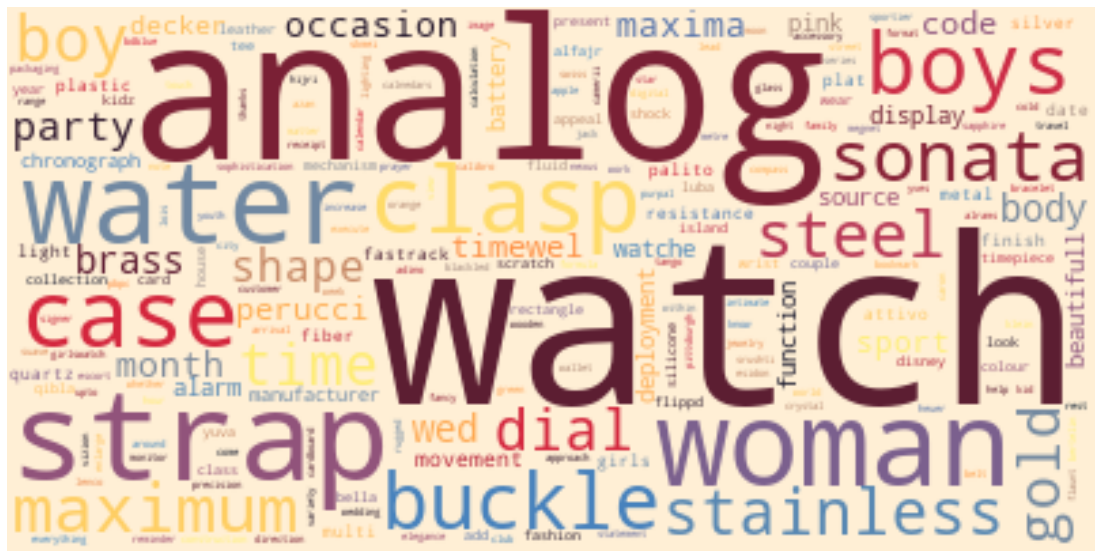

In [47]:
hero.wordcloud(corpus_final[corpus_final['categories'] ==
               'Watches']['description_lemmatisation'], max_words=200,)

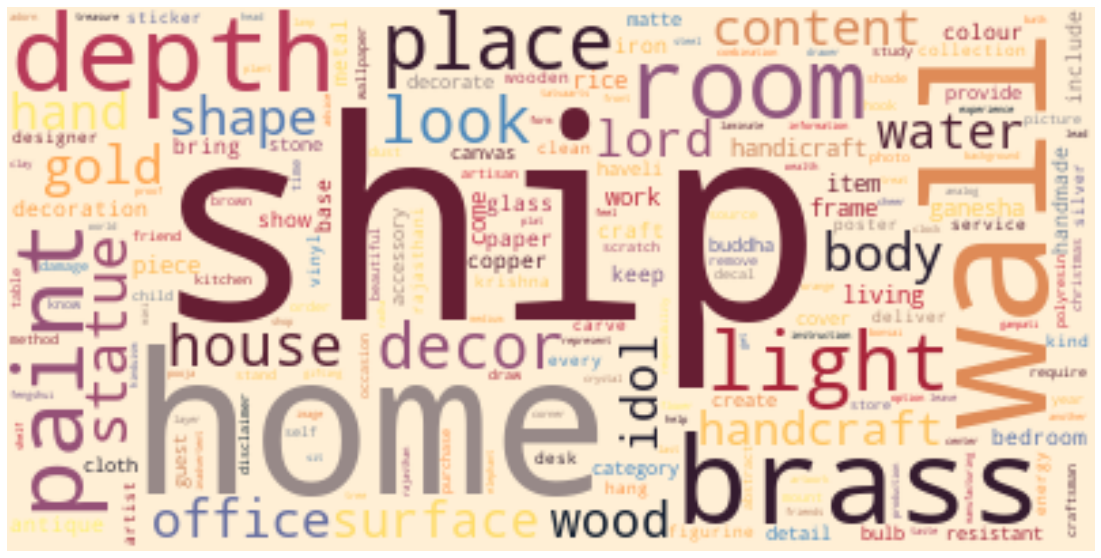

In [48]:
hero.wordcloud(corpus_final[corpus_final['categories'] ==
               'HomeDecorFestiveNeeds']['description_lemmatisation'],
               max_words=200,)

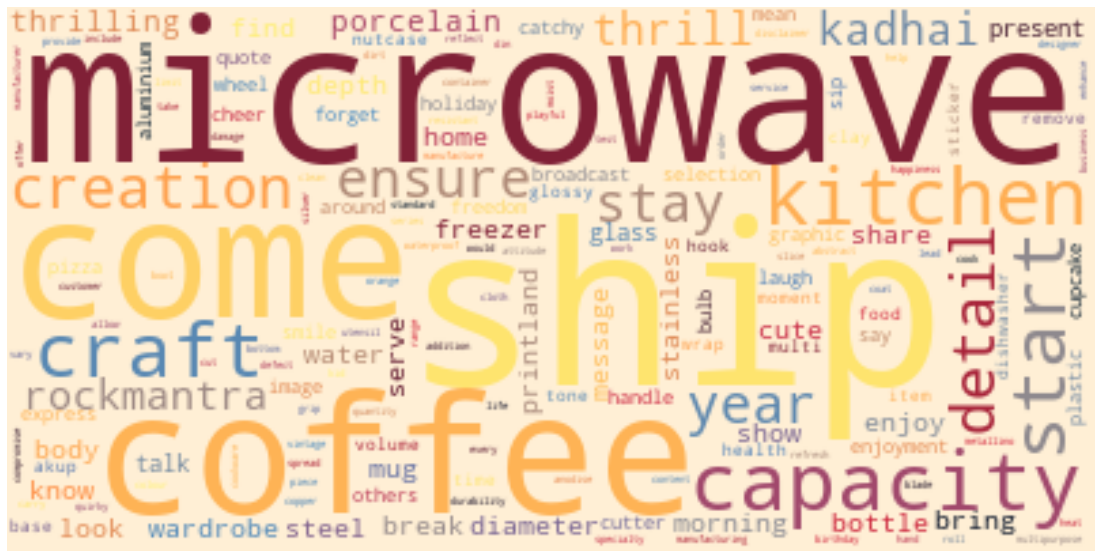

In [49]:
hero.wordcloud(corpus_final[corpus_final['categories'] ==
               'KitchenDining']['description_lemmatisation'], max_words=200,)

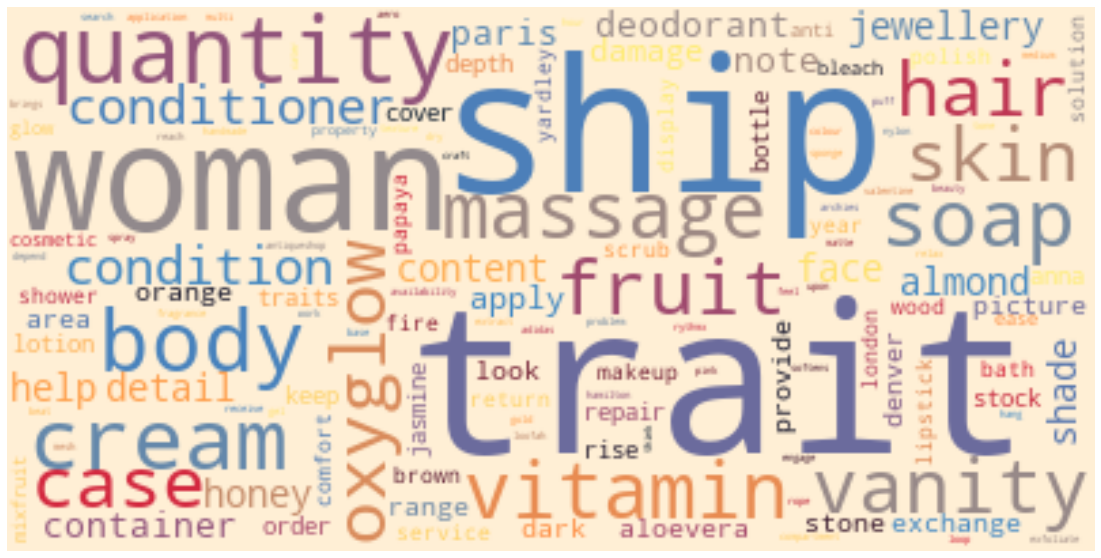

In [50]:
hero.wordcloud(corpus_final[corpus_final['categories'] ==
               'BeautyandPersonalCare']['description_lemmatisation'],
               max_words=200,)

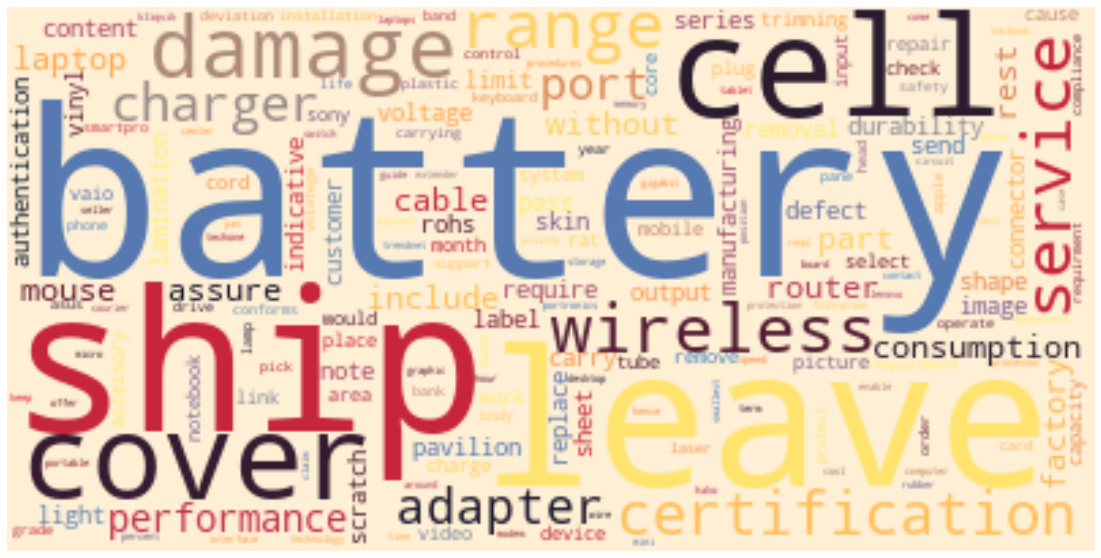

In [51]:
hero.wordcloud(corpus_final[corpus_final['categories'] ==
               'Computers']['description_lemmatisation'], max_words=200,)

## count vectorizer BOW
Nous allons créer un vecteur, où chaque élément de ce vecteur correspond à un mot du bag of words, et où chaque valeur de chaque élément du vecteur correspondrait au nombre d'occurrences du mot dans la description du produit

In [53]:
# Pour les descriptions des produits

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(encoding='utf-8',
                             analyzer='word',
                             min_df=0.001,
                             max_df=0.9,
                             max_features=5000,
                             ngram_range=(1, 2))

X = vectorizer.fit_transform(corpus_final["description_lemmatisation"])
count_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

###

vectorizer_1 = CountVectorizer(encoding='utf-8',
                               analyzer='word',
                               min_df=0.001,
                               max_df=0.9,
                               max_features=5000,
                               ngram_range=(1, 1))

X_1 = vectorizer_1.fit_transform(corpus_final["description_lemmatisation"])
count_df_1 = pd.DataFrame(
    X_1.toarray(), columns=vectorizer_1.get_feature_names())

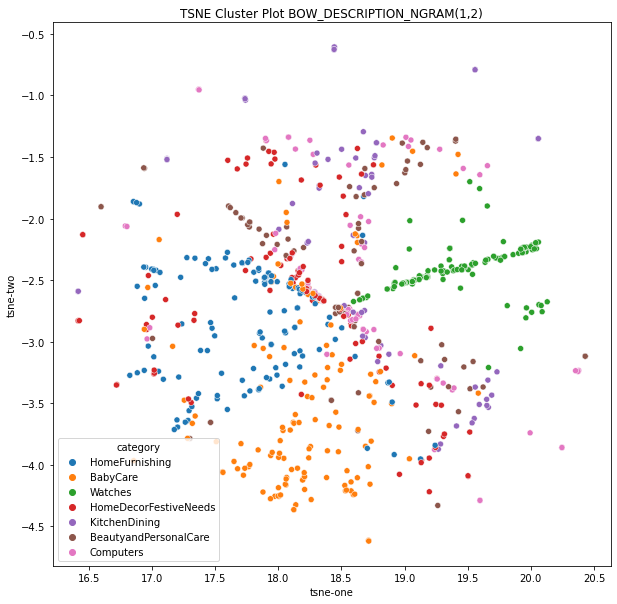

In [54]:
plot_tsne(count_df, 'BOW_DESCRIPTION_NGRAM(1,2)', corpus_final['categories'])

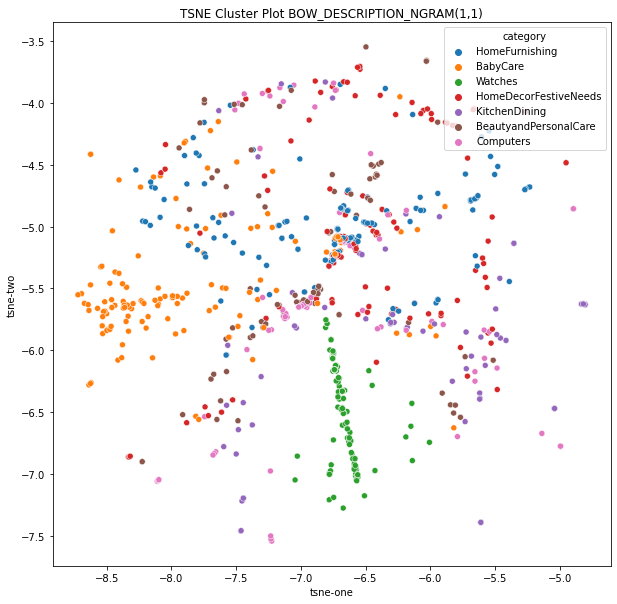

In [55]:
plot_tsne(count_df_1, 'BOW_DESCRIPTION_NGRAM(1,1)', corpus_final['categories'])

## tfidf vectorizer
Term Frequency – Inverse Document Frequency est une mesure qui permet, à partir d’un ensemble de textes, de connaître l’importance
relative de chaque mot. Cel va nous permettre de créer une matrice de vecteurs, où chaque élement du vecteur représente un mot
du bag of word et la valeur de chaque élément du vecteur représente l'importance d'un mot relativisé à l'ensemble des documents.

In [56]:
# Pour les descriptions des produits
tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                                   analyzer='word',
                                   min_df=0.01,
                                   max_features=None,
                                   ngram_range=(1, 2))

X_tfidf = tfidf_vectorizer.fit_transform(
    corpus_final["description_lemmatisation"])
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())

#####
tfidf_vectorizer_1 = TfidfVectorizer(encoding='utf-8',
                                     analyzer='word',
                                     min_df=0.01,
                                     max_features=None,
                                     ngram_range=(1, 1))

X_tfidf_1 = tfidf_vectorizer_1.fit_transform(
    corpus_final["description_lemmatisation"])
tfidf_df_1 = pd.DataFrame(
    X_tfidf_1.toarray(), columns=tfidf_vectorizer_1.get_feature_names())

###

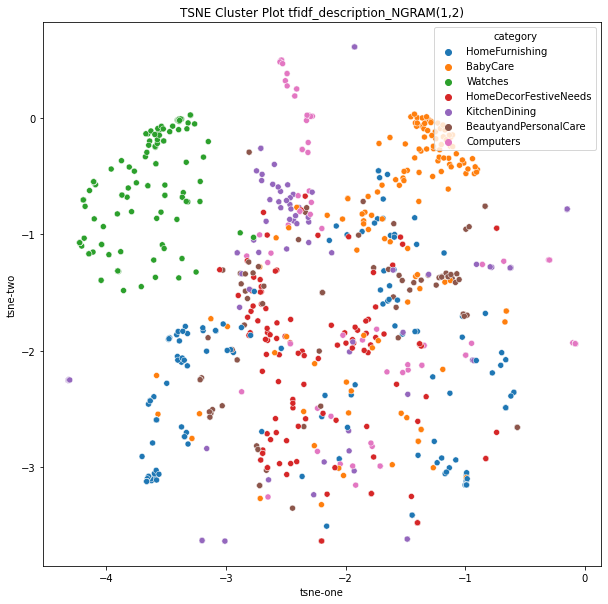

In [57]:
plot_tsne(tfidf_df, 'tfidf_description_NGRAM(1,2)', corpus_final['categories'])

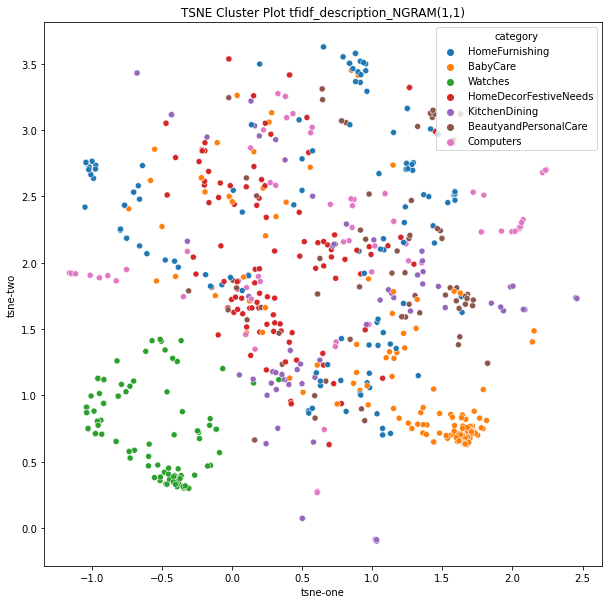

In [58]:
plot_tsne(tfidf_df_1, 'tfidf_description_NGRAM(1,1)',
          corpus_final['categories'])

## PCA
Afin d'améliorer les performances et le temps de calcul de notre clustering, nous allons appliquer une réduction de dimension à nos matrices count_vect et tf-idf avec une variance de 95%

# T-SNE
Par la suite pour permettre la visualison de nos matrices nous vons appliquer le T-SNE

### Count_vect

Dimensions dataset après réduction PCA :  (1050, 376)



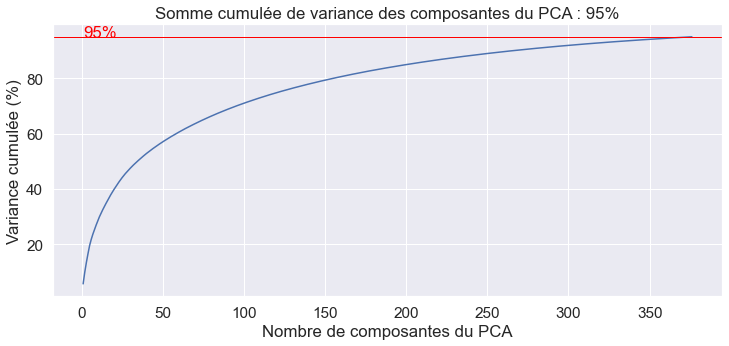

In [166]:
pca, count_df_pca = pca_function(count_df)
pca_graph(pca)

Dimensions dataset après réduction tsne :  (1050, 2)



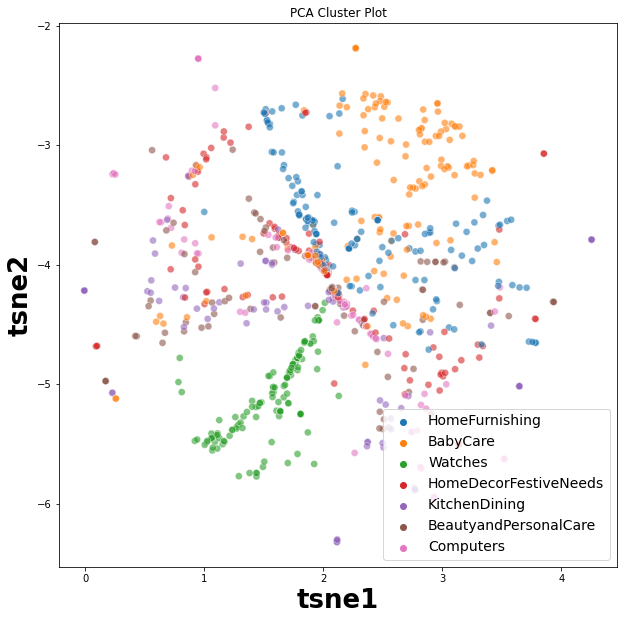

In [62]:
tsne, tsne_count_df, df_count_df = tsne_pca(count_df_pca)
df_count_df["categories"] = produits['categories']
tsne_graph(df_count_df)

### count_vect_1

Dimensions dataset après réduction PCA :  (1050, 330)



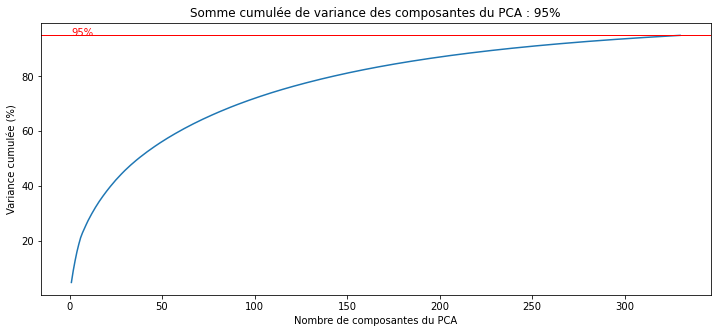

In [63]:
pca, count_df_1_pca = pca_function(count_df_1)
pca_graph(pca)

Dimensions dataset après réduction tsne :  (1050, 2)



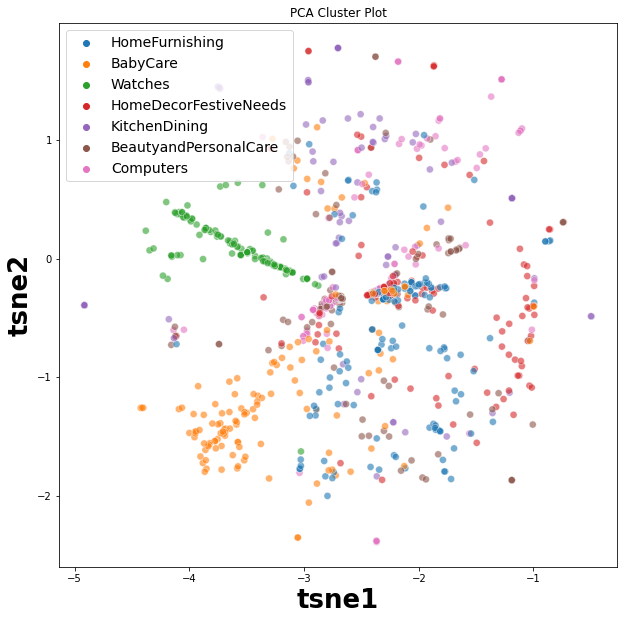

In [64]:
tsne, tsne_count_df_1, df_count_df1 = tsne_pca(count_df_1_pca)
df_count_df1["categories"] = produits['categories']
tsne_graph(df_count_df1)

### TF_idf

Dimensions dataset après réduction PCA :  (1050, 165)



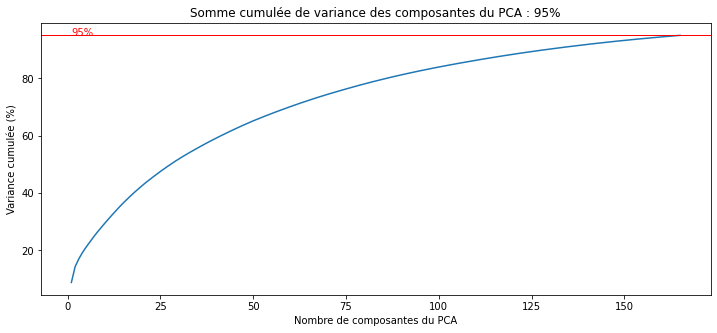

In [65]:
pca, tfidf_df_pca = pca_function(tfidf_df)
pca_graph(pca)

Dimensions dataset après réduction tsne :  (1050, 2)



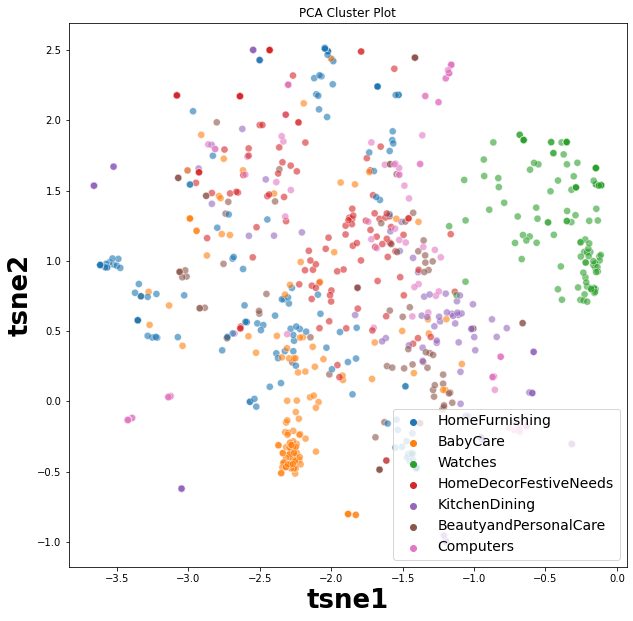

In [66]:
tsne, tsne_tfidf_df, df_tfidf_df = tsne_pca(tfidf_df_pca)
df_tfidf_df["categories"] = produits['categories']
tsne_graph(df_tfidf_df)

### Tfidf_1

Dimensions dataset après réduction PCA :  (1050, 151)



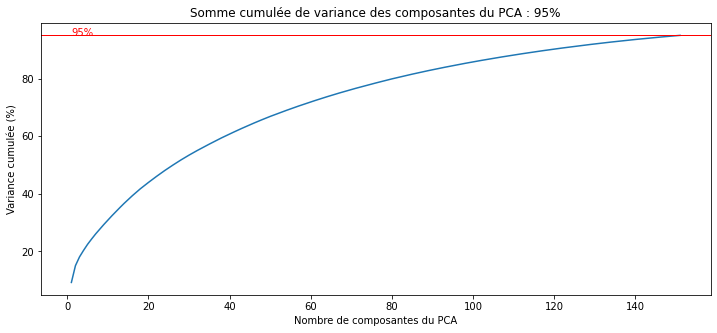

In [67]:
pca, tfidf_df_pca_1 = pca_function(tfidf_df_1)
pca_graph(pca)

Dimensions dataset après réduction tsne :  (1050, 2)



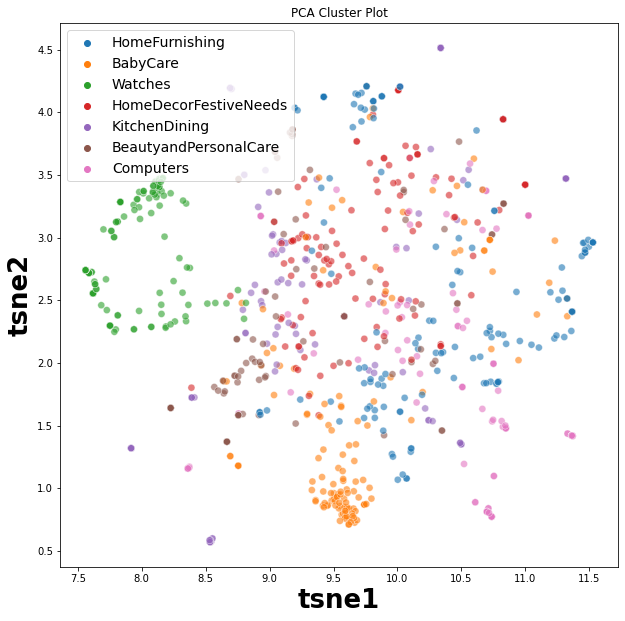

In [68]:
tsne, tsne_tfidf_df_1, df_tfidf_df_1 = tsne_pca(tfidf_df_pca_1)
df_tfidf_df_1["categories"] = produits['categories']
tsne_graph(df_tfidf_df_1)

## Kmeans, adjusted_rand_score

A partir de la matrice PCA/T-sne nous allons appliquer l'algorithme K-means sur nos dooonées pour les regrouper dans 7 clusters correspondant à nos catégories 

In [69]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7,
                random_state=10,
                init='k-means++',
                n_jobs=-1)
model_kmeans = kmeans.fit(tfidf_df_pca)

In [70]:
label = kmeans.fit_predict(tfidf_df_pca)
model_kmeans.labels_.shape

(1050,)

In [71]:
list_kmean = model_kmeans.labels_
list_kmean = list(set(list_kmean))
list_kmean

[0, 1, 2, 3, 4, 5, 6]

In [72]:
labels_kmeans = pd.DataFrame(model_kmeans.labels_, columns=['kmeans_cluster'])

kmeans_cluster
0               1
1               1
2               1
3               1
4               1
5               3
6               3
7               3
8               1
9               3

In [73]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples
silhouette_kmeans = silhouette_score(
    X=tfidf_df_pca, labels=model_kmeans.labels_)
print('Le coefficient de silhouette moyen est de {} pour la méthode K-means'.format(silhouette_kmeans))

Le coefficient de silhouette moyen est de 0.11930941380784185 pour la méthode K-means


In [74]:
label = pd.concat(
    [corpus_final['categories'], produits['label_categories'], labels_kmeans], axis=1)

In [75]:
label['label_categories']

0       0
1       1
2       1
3       0
4       0
       ..
1045    1
1046    1
1047    1
1048    1
1049    1
Name: label_categories, Length: 1050, dtype: int64

#### ARI
L'adjusted_rand_score calcule une mesure de similarité entre deux groupements en considérant toutes les paires d'échantillons
et en comptant les paires qui sont assignées dans le même groupement ou dans des groupements différents dans les groupements prédits et réels.

In [76]:
ARI_kmeans = adjusted_rand_score(
    label['label_categories'], label['kmeans_cluster'])
print('Le score ARI est de {} pour la méthode K-means'.format(ARI_kmeans))

Le score ARI est de 0.16063029022755046 pour la méthode K-means


#### Visualisation des erreurs d'attributions

Grace à la matrice de confusion, nous allons pouvoir visualiser les errereurs d'attributions.

In [77]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(label['label_categories'], label['kmeans_cluster'])

In [78]:
table_label = pd.pivot_table(label, values='label_categories', index=['categories'],
                             columns=['kmeans_cluster'], aggfunc=lambda x: len(x), fill_value=0)

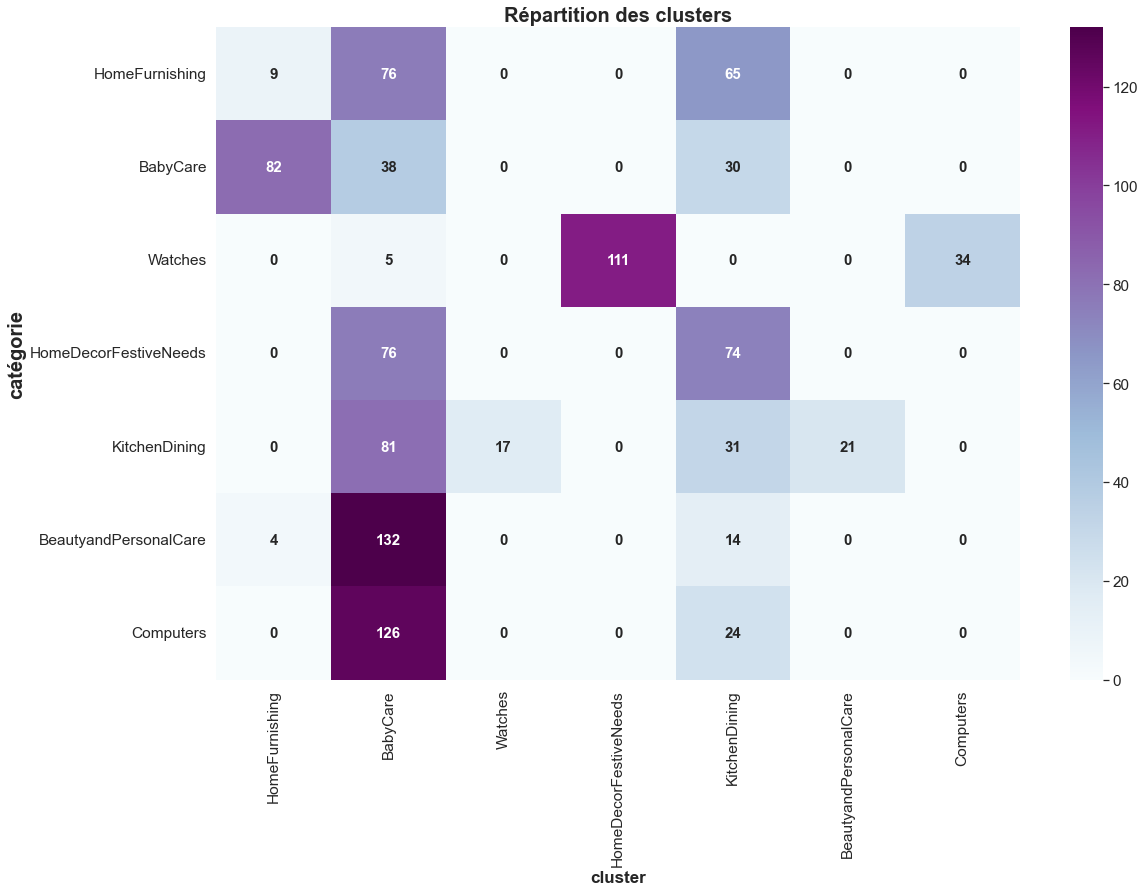

In [164]:
list_labels = ['HomeFurnishing', 'BabyCare', 'Watches', 'HomeDecorFestiveNeeds',
               'KitchenDining', 'BeautyandPersonalCare', 'Computers']
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[label for label in list_labels])
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('cluster', weight='bold', size=17)
plt.show()

Nous voyons que la méthode des kmeans ne fonctionne pas pour le NLP

# Réalisation de clustering différents 
LDA, PLSA, LSA. LDA

### LDA

utilisation de count vectorize count_df_pca

In [167]:
def plot_tsne_lda(matrix, title, labels):

    tsne = TSNE(n_components=2,
                random_state=5,
                perplexity=100,
                n_iter=5000).fit_transform(matrix)

    tsne_data = np.vstack((tsne.T, labels)).T
    tsne_df = pd.DataFrame(tsne_data,
                           columns=['tsne-one', 'tsne-two', 'category'])

    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    sns.scatterplot(data=tsne_df,
                    x="tsne-one",
                    y="tsne-two",
                    hue='category',
                    ax=ax)
    plt.title('TSNE Cluster Plot'+' '+title)

Utiliser count vectorizer

In [169]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 7

lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=10,
                                learning_method='online',
                                random_state=100,
                                batch_size=128,
                                evaluate_every=-1,
                                n_jobs=-1)

text_lda = lda.fit_transform(count_df)
LDA_count = pd.DataFrame(
    text_lda, columns=['topic_'+str(i+1) for i in range(n_topics)])

In [84]:
def display_topics(lda, feature_names, no_top_words):
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


no_top_words = 16
display_topics(lda, vectorizer.get_feature_names(), no_top_words)

Topic 0:
cover battery damage manufacturing cell battery cell service defect manufacturing defect adapter charger consumption certification limit part rest
Topic 1:
watch analog analog watch baby cotton content detail strap water occasion woman code sleeve watch woman neck case
Topic 2:
home sticker look steel vinyl room wall stainless colour stainless steel vinyl sticker water depth place shape collection
Topic 3:
craft detail microwave come year creation ensure quilt comforter quilt comforter start stay thrill start year come craft ensure thrilling
Topic 4:
coffee bring cream bottle kitchen vitamin break others wardrobe mean know home share printland show present
Topic 5:
content skin leave shape body range polyester mouse would remove without require curtain skin mouse sheet eyelet
Topic 6:
ship sticker ship blanket abstract sticker blanket ship kadhai kadhai ship soap medium raymond dohar handicraft import abstract blanket plain


## Deuxième méthode de visualisation pour LDA

In [85]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import gensim
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models

In [86]:
df_lemmatisation = hero.tokenize(corpus["description_lemmatisation"])

In [87]:
# Creation d'un dictionnaire
id2word = corpora.Dictionary(df_lemmatisation)
# Creation du corpus
texts = df_lemmatisation
# La fréquence des termes dans le document
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)]]


In [88]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=7,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [89]:
# Print les mot-clé des sujets
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.070*"watch" + 0.065*"analog" + 0.040*"scratch" + 0.040*"sticker" + '
  '0.036*"water" + 0.029*"strap" + 0.028*"woman" + 0.022*"vinyl" + '
  '0.021*"case" + 0.015*"boys"'),
 (1,
  '0.028*"aroma" + 0.016*"apply" + 0.014*"face" + 0.012*"microwave" + '
  '0.011*"freezer" + 0.011*"trait" + 0.011*"paper" + 0.009*"carry" + '
  '0.008*"depth" + 0.007*"polymer"'),
 (2,
  '0.096*"ship" + 0.020*"polyester" + 0.018*"body" + 0.017*"curtain" + '
  '0.015*"home" + 0.015*"eyelet" + 0.013*"colour" + 0.013*"blanket" + '
  '0.011*"light" + 0.011*"keep"'),
 (3,
  '0.025*"towel" + 0.023*"steel" + 0.019*"bath" + 0.016*"stainless" + '
  '0.016*"gold" + 0.013*"battery" + 0.013*"paint" + 0.011*"device" + '
  '0.010*"premium" + 0.009*"frame"'),
 (4,
  '0.038*"range" + 0.024*"look" + 0.022*"home" + 0.019*"kitchen" + '
  '0.015*"provide" + 0.014*"month" + 0.010*"port" + 0.010*"note" + '
  '0.010*"customer" + 0.009*"order"'),
 (5,
  '0.048*"content" + 0.046*"cotton" + 0.034*"baby" + 0.033*"detail" + '
  

In [90]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


coherence_model_lda = CoherenceModel(
    model=lda_model, texts=df_lemmatisation, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.662895023129652

Coherence Score:  0.463592230405915


Plus perplexity est négatif et plus le cohérence score est proche de 1 mieux notre traitement est effectué 

### Visualisation des topics 

In [91]:
pyLDAvis.enable_notebook()
visualisation = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
visualisation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.252667 -0.208173       1        1  23.680714
2      0.199254 -0.145535       2        1  20.642762
5     -0.123103  0.248690       3        1  17.388080
4      0.122211  0.048957       4        1  12.485188
3      0.053191  0.010414       5        1   9.790479
0     -0.036217  0.016675       6        1   9.306454
1      0.037331  0.028971       7        1   6.706323, topic_info=               Term        Freq       Total Category  logprob  loglift
259            ship  246.000000  246.000000  Default  30.0000  30.0000
99            watch   81.000000   81.000000  Default  29.0000  29.0000
97           analog   75.000000   75.000000  Default  28.0000  28.0000
45           cotton   99.000000   99.000000  Default  27.0000  27.0000
7           content  159.000000  159.000000  Default  26.0000  26.0000
365            baby   75.000000   75.000000  Default  25.0000  25.0000
366          detail   71.000000   71.000000  Default  24.0000  24.0000
152           range   59.000000   59.000000  Default  23.0000  23.0000
639         sticker   51.000000   51.000000  Default  22.0000  22.0000
140         scratch   47.000000   47.000000  Default  21.0000  21.0000
72            water   63.000000   63.000000  Default  20.0000  20.0000
86          comfort   56.000000   56.000000  Default  19.0000  19.0000
51            woman   52.000000   52.000000  Default  18.0000  18.0000
20             home   73.000000   73.000000  Default  17.0000  17.0000
641           vinyl   65.000000   65.000000  Default  16.0000  16.0000
235            code   48.000000   48.000000  Default  15.0000  15.0000
221           strap   34.000000   34.000000  Default  14.0000  14.0000
180           shape   73.000000   73.000000  Default  13.0000  13.0000
566        occasion   46.000000   46.000000  Default  12.0000  12.0000
28        polyester   52.000000   52.000000  Default  11.0000  11.0000
395          remove   54.000000   54.000000  Default  10.0000  10.0000
75            cover   53.000000   53.000000  Default   9.0000   9.0000
50            towel   30.000000   30.000000  Default   8.0000   8.0000
796          sleeve   41.000000   41.000000  Default   7.0000   7.0000
23             look   62.000000   62.000000  Default   6.0000   6.0000
198           steel   28.000000   28.000000  Default   5.0000   5.0000
9           curtain   44.000000   44.000000  Default   4.0000   4.0000
260           aroma   24.000000   24.000000  Default   3.0000   3.0000
464         kitchen   29.000000   29.000000  Default   2.0000   2.0000
164            case   28.000000   28.000000  Default   1.0000   1.0000
395          remove   54.246912   54.889936   Topic1  -3.9935   1.4287
75            cover   52.651088   53.291712   Topic1  -4.0234   1.4284
83            sheet   44.446843   45.087841   Topic1  -4.1927   1.4262
1693        without   41.087259   41.727743   Topic1  -4.2713   1.4250
865           mouse   39.931188   40.571217   Topic1  -4.2999   1.4246
804         require   38.382046   39.024124   Topic1  -4.3394   1.4239
2645     lamination   37.304038   37.944396   Topic1  -4.3679   1.4235
1861         laptop   37.177326   37.817172   Topic1  -4.3713   1.4234
400           would   38.597795   39.282446   Topic1  -4.3338   1.4229
2992        removal   34.613486   35.254062   Topic1  -4.4428   1.4222
2993       trimning   34.613486   35.254062   Topic1  -4.4428   1.4222
564            pink   33.580339   34.229142   Topic1  -4.4731   1.4214
594           brown   32.810904   33.455702   Topic1  -4.4963   1.4210
49             self   31.352235   32.000011   Topic1  -4.5418   1.4201
98             time   25.372628   26.015523   Topic1  -4.7534   1.4155
302           craft   24.602770   25.244456   Topic1  -4.7842   1.4148
446           place   23.470016   24.111636   Topic1  -4.8313   1.4135
418         service   24.514828   25.197737   Topic1  -4.7878  

## LDA visualisation tsne

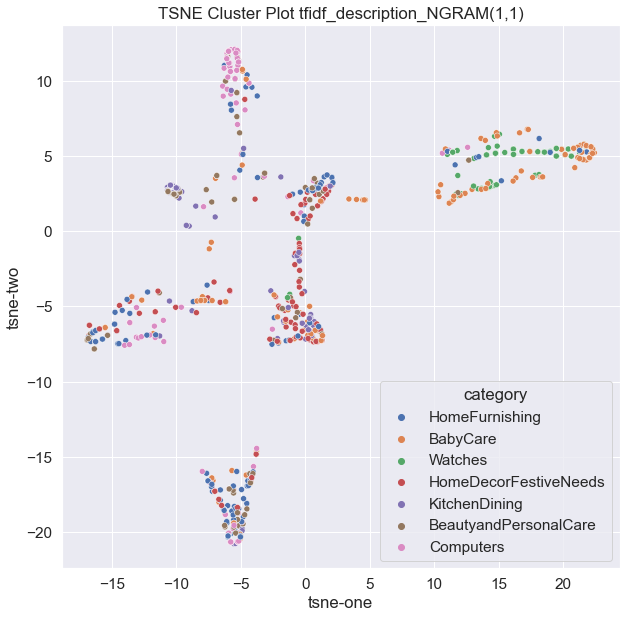

In [92]:
plot_tsne_lda(LDA_count, 'tfidf_description_NGRAM(1,1)',
              corpus_final['categories'])

In [93]:
import pickle

In [94]:
print('Nombre de topics:', len(lda.components_))
print('Nombre de colonne pour la methode lda :', len(lda.components_[0]))

Nombre de topics: 7
Nombre de colonne pour la methode lda : 2569


In [95]:
label_lda = lda.components_

corpus_final['topic'] = text_lda.argmax(axis=1)

corpus_final.head(30)

categories  \
0   HomeFurnishing   
1         BabyCare   
2         BabyCare   
3   HomeFurnishing   
4   HomeFurnishing   
5          Watches   
6          Watches   
7          Watches   
8          Watches   
9          Watches   
10         Watches   
11         Watches   
12         Watches   
13         Watches   
14         Watches   
15         Watches   
16         Watches   
17         Watches   
18         Watches   
19         Watches   
20         Watches   
21         Watches   
22         Watches   
23         Watches   
24         Watches   
25         Watches   
26         Watches   
27         Watches   
28         Watches   
29         Watches   

                                                                                                                                                                                                                                                                                              description_lemmatisation  \
0   elegance polyester eyelet door curtain enhances look interior stitch metal ring room environment loving wrinkle shrinkage apparance home bright appeal attention heart valance slide thing morning ray want world draw evening create moment beauty soothe bring elegant filter light right amount sunlight content   
1                                                                                                                                                                                                                                                     sathiyas cotton bath towel machine self woman boys mediam content   
2                                                                                                               eurospa cotton terry face towel piece bring export texture take enrich feel deserve bath renowned year absorbency softness durability note shrinkage picture water iron bleach assort boy woman content   
3                                                                                                                                                                                                          santosh fashion cotton king bedsheet perfact wed cover machine wedding pillow bleach sheet fit depth content   
4                                                                                                                                                  jaipur cotton king bedsheet sheet comfort hand look room life cover machine thread count bleach waranty manufacturing exchange onle packing fit pillow depth content   
5                                                                                                                                                                                                                                                                                                time analog watch boys   
6                                                                                                                                                                                                                                                                                    camerii elegance analog watch boys   
7                                                                                                                                                                 star analog watch boys whether work travel family accessory wallet belt help touch sophistication class wear come suave leather finish timepiece rest   
8                                                                                                                                                                                                    alfajr youth watch boy azan time city around world prayer reminder qibla direction hijri calnedars bookmark alrams   
9                                                                                                                                                                              

### Intégration de nos topics dans un nouveau df

In [96]:
LDA_label = pd.concat(
    [corpus_final['categories'], produits['label_categories'], corpus_final['topic']], axis=1)

In [124]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from sklearn import cluster, metrics

labels_lda = LDA_label["categories"]

ARI = adjusted_rand_score(labels_lda, LDA_label["topic"])
silhouette_lda = metrics.silhouette_score(LDA_count, LDA_label['topic'])
db_score_lda = davies_bouldin_score(LDA_count, LDA_label['topic'])
print(
    f"DB score = {db_score_lda} --- silhouette = {silhouette_lda} ---- ARI = {ARI}")

DB score = 0.5741891884025542 --- silhouette = 0.6401933064743902 ---- ARI = 0.23692780063081684


### Visualisation des erreurs du modèle 

In [125]:
conf_mat_LDA = confusion_matrix(
    LDA_label['label_categories'], LDA_label['topic'])

In [160]:
table_label_lda = pd.pivot_table(LDA_label, values='label_categories', index=['categories'],
                                 columns=['topic'], aggfunc=lambda x: len(x), fill_value=0)

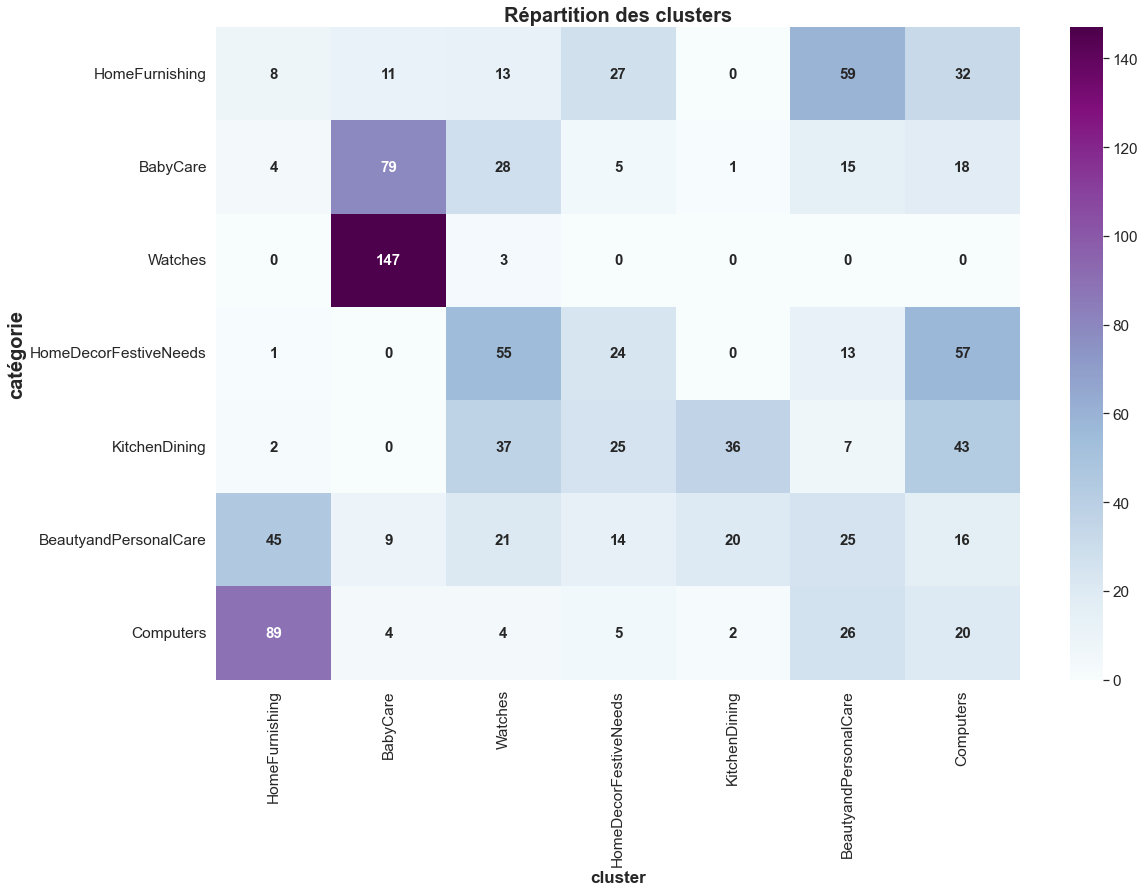

In [165]:
list_labels = ['HomeFurnishing', 'BabyCare', 'Watches', 'HomeDecorFestiveNeeds',
               'KitchenDining', 'BeautyandPersonalCare', 'Computers']
df_cm = pd.DataFrame(conf_mat_LDA, index=[label for label in list_labels],
                     columns=[label for label in list_labels])
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('cluster', weight='bold', size=17)
plt.show()

## LSA

In [147]:
from sklearn.decomposition import TruncatedSVD
n_topics = 7
lsa_model = TruncatedSVD(n_components=n_topics,
                         algorithm='randomized',
                         n_iter=10,
                         random_state=42)

lsa_top = lsa_model.fit_transform(count_df_1)
lsa_count = pd.DataFrame(
    lsa_top, columns=['topic_'+str(i+1) for i in range(n_topics)])

In [148]:
print(lsa_top[0])
print(lsa_top.shape)

[ 0.98117826 -0.40247525 -0.17248291  0.44383463  0.35131683  0.0789856
  1.43066801]
(1050, 7)


In [149]:
l = lsa_top[0]
for i, topic in enumerate(l):
    print("Topic ", i, " : ", topic*100)

Topic  0  :  98.11782628697301
Topic  1  :  -40.247525449532844
Topic  2  :  -17.24829116252965
Topic  3  :  44.38346295119915
Topic  4  :  35.13168339111847
Topic  5  :  7.898559842437555
Topic  6  :  143.06680057975032


In [150]:
vocab = vectorizer_1.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key=lambda x: x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0], end=" ")
    print("\n")

Topic 0: 
content detail cotton baby water occasion cover code watch sleeve 

Topic 1: 
battery damage service certification customer manufacturing part performance defect factory 

Topic 2: 
watch analog strap water woman case clasp buckle steel maximum 

Topic 3: 
coffee bring show mug know find cheer holiday mean break 

Topic 4: 
ship home blanket quilt comforter craft abstract kadhai towel bath 

Topic 5: 
come craft year microwave ensure creation start stay porcelain rockmantra 

Topic 6: 
home look depth content remove shape room range body skin 



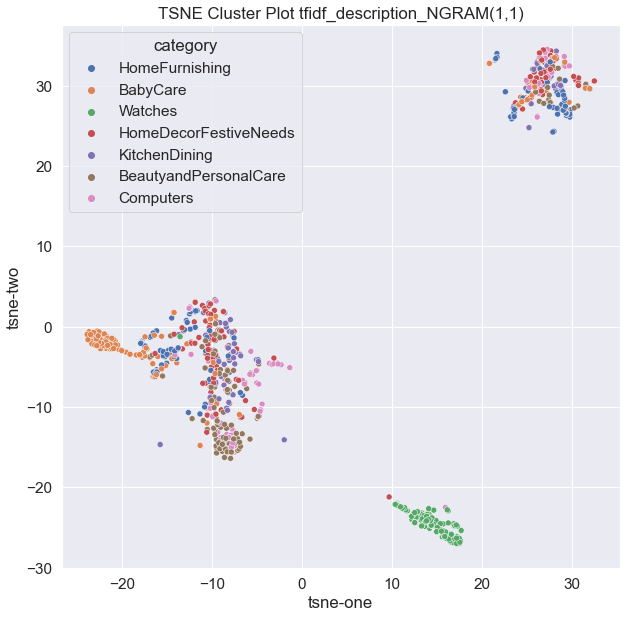

In [151]:
plot_tsne_lda(lsa_count, 'tfidf_description_NGRAM(1,1)',
              corpus_final['categories'])

In [152]:
print('Number of topics:', len(lsa_model.components_))
print('Number of columns of the lsa fit:', len(lsa_model.components_[0]))

Number of topics: 7
Number of columns of the lda fit: 1339


In [153]:
label_lsa = lsa_model.components_

corpus_final['topic_lsa'] = lsa_top.argmax(axis=1)

In [154]:
LSA_label = pd.concat(
    [corpus_final['categories'], produits['label_categories'], corpus_final['topic_lsa']], axis=1)

In [155]:
labels_lsa = LSA_label["categories"]

ARI = adjusted_rand_score(labels_lsa, LSA_label["topic_lsa"])
silhouette_lsa = metrics.silhouette_score(lsa_count, LSA_label["topic_lsa"])
db_score_lsa = davies_bouldin_score(lsa_count, corpus_final['topic_lsa'])
print(
    f"DB score = {db_score_lsa} --- silhouette = {silhouette_lsa} ---- ARI = {ARI}")

DB score = 1.5326311048238863 --- silhouette = 0.2996867572449054 ---- ARI = 0.2114995196089896


### Visualisation des erreurs du modèle 

In [156]:
conf_mat_LSA = confusion_matrix(
    LSA_label['label_categories'], LSA_label['topic_lsa'])

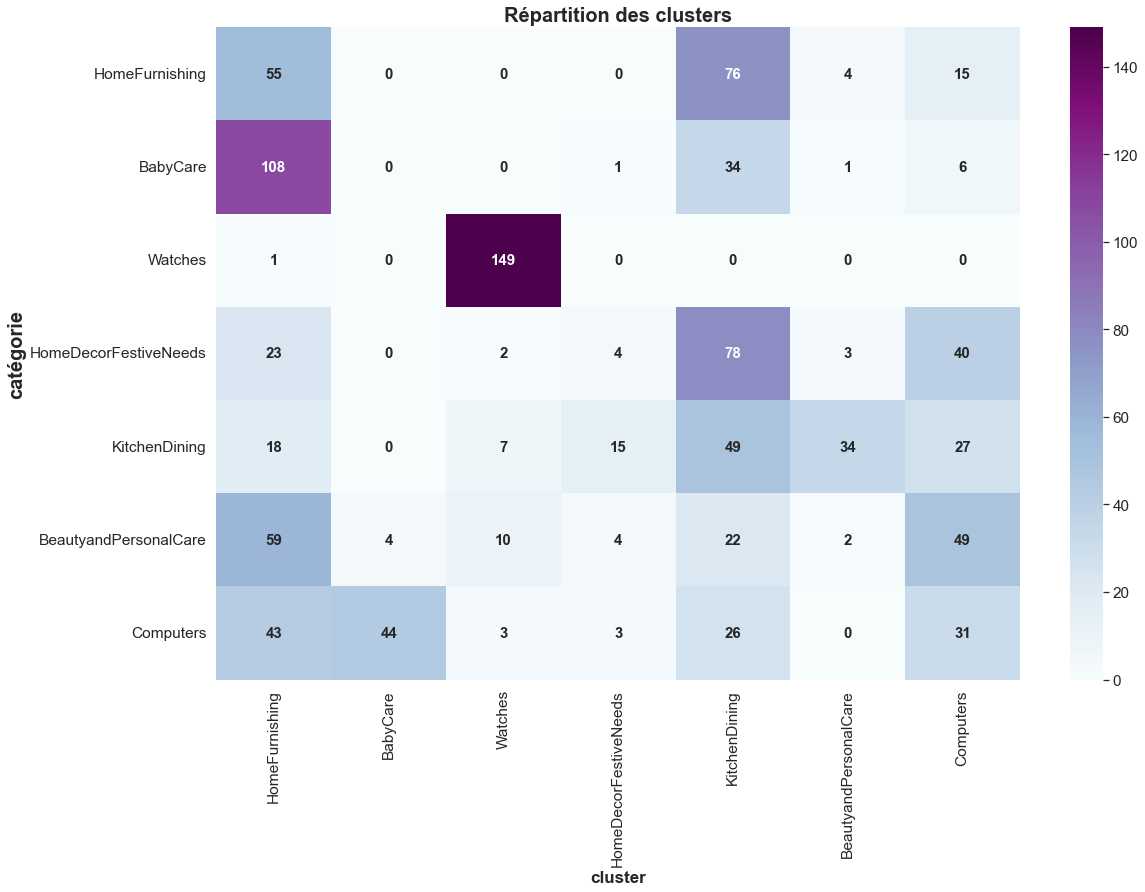

In [163]:
list_labels = ['HomeFurnishing', 'BabyCare', 'Watches', 'HomeDecorFestiveNeeds',
               'KitchenDining', 'BeautyandPersonalCare', 'Computers']
df_cm = pd.DataFrame(conf_mat_LSA, index=[label for label in list_labels],
                     columns=[label for label in list_labels])
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('cluster', weight='bold', size=17)
plt.show()

In [159]:
# bert
# Les montres sont biens classés